In [1]:
%matplotlib inline
import itertools
import numpy as np

#Teneur en eau résiduelle
tr = [0.03]
#Teneur en eau à saturation
ts=np.arange(0.36, 0.46, 0.02, 'float')
#ts= [0.4]
#Teneur en eau initiale
#ti=np.arange(0.05, 0.13, 0.02, 'float')
ti = [0.07]
#Perméabilité à saturation
Ks=np.arange(0.01, 0.56, 0.05, 'float')
#Ks = [0.51]
#param fitting retention n
n=np.arange(1.5, 10.25, 0.25, 'float')
#n = [4.0]
#param fitting retention alpha
alpha=np.arange(0.01, 0.11, 0.01, 'float')
#alpha = [0.03]


In [2]:
import os

from modelisation import Geometry, ParamMVG, ParamGPRMAX

geometry=Geometry()

#Domaine de calcul (en cm)
# largeur
geometry.xmin=0 
geometry.xmax=40
# hauteur (elevation)
geometry.emin=0
geometry.emax = 80
# profondeur du trou en cm
geometry.dtrou = 30
# elevation du fond du trou
geometry.etrou = geometry.emax - geometry.dtrou
 # rayon du trou en cm
geometry.r=4
# hauteur d'eau imposée au fond du trou en cm
geometry.h_eau=5.0
# pas de la maille en cm
geometry.dx = 0.1
#geometry.dx = 1
# profondeur sous le trou (cm) jusqu'où on souhaite un maillage affiné. 
geometry.zaff= 20
#largeur horizontal de la zone affinée (cm)
geometry.waff=20
# elevation de l'affinage
geometry.eaff=geometry.etrou-geometry.zaff 
# contrainte d'angle min pour mesh 
geometry.quality=33
# maximum triangle size  (m*²)
geometry.area=5
# tupple for mesh generation 
geometry.smooth=[1,5]


#Temps d'infiltration où à lieu le calcul de chaque trace  (minutes) 
#temps=[1.00, 2.00]
temps=[0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 2.00, 3.00, 4.00, 5.00, 6.00]

# Temps max de calcul SWMS2D au delà duquel on arrète le calcul (secondes)
tmax_SWMS2D = 600
#tmax_SWMS2D = 10
   
# Definition des param gprMax
paramGPRMAX=ParamGPRMAX()
# Domaine de calcul (cm)
paramGPRMAX.xmin = geometry.xmin
paramGPRMAX.xmax = geometry.xmax
paramGPRMAX.zmin = geometry.emin
paramGPRMAX.zmax = geometry.emax
# Taille des mailles (cm)
paramGPRMAX.dx = 1.0 
# Electrical conductivity of the medium
paramGPRMAX.sigma=0.0000
# Relative dielectric permittivity of water
paramGPRMAX.eps_w=80.1
# Relative dielectric permittivity of PVC
paramGPRMAX.eps_pvc=3
# Relative dielectric permittivity of pure silice
paramGPRMAX.eps_s=2.5
# Ricker signal central frequency (Hz)
paramGPRMAX.wave_freq = 1000e6
# Frequence max du signal EM (Hz)
paramGPRMAX.freq_max = 2.8 * paramGPRMAX.wave_freq
# Distance between hole middle and source (m)
paramGPRMAX.d_emet = 0.18
# Distance between hole middle and receiving antenna (m)
paramGPRMAX.d_recept = 0.22
# param qui raffine le pas spatial (par défaut 10 d'après doc gprmax)
paramGPRMAX.spatial_step = 5
# Trace time window (ns)
paramGPRMAX.time = 30e-9
#time_step_stability_factor (pas utilisé pour le moment...)
paramGPRMAX.fac_dt = 0.2 

nT=len(temps)


In [3]:
import h5py
import math
import numpy as np
from scipy.stats import linregress

def CRIM(theta, paramMVG, paramGPRMAX):
    """Compute the relative permittivity value corresponding to the water content theta using CRIM relation"""
    return round(( math.sqrt(paramGPRMAX.eps_w)*theta+(1-paramMVG.porosity)*math.sqrt(paramGPRMAX.eps_s)+(paramMVG.porosity-theta) )**2,3)



def picking(filename, nT, geometry, ti): 
    """ Search for TWT of the wave going around the bulb in each traces.
    The minimum TWT is computed using the geometry and min relative permittivity.
    On each trace, it searches the max amplitude TWT. Then the min TWT just before and the min TWT just after.
    It fits the three curves TWT(itrace) with a power law and take the one with the best fit. 
    
    """
    #TODO:ajuster les tailles de fenetre... C'est un peu bizarre pour le moment.
    
    f = h5py.File(filename, 'r')
    path = '/rxs/rx1/'
    samples = f.attrs['Iterations']
    dt = f.attrs['dt']*1e9 # en ns
    dx = 1
    data = np.ones((samples, nT+1))
    t_max = np.zeros(nT+1)
    t_min1 = np.zeros(nT+1)
    t_min2 = np.zeros(nT+1)
    tt=np.zeros(nT+1)
    tt_min1 = np.zeros(nT+1)
    tt_min2 = np.zeros(nT+1)
    tps_max = np.zeros(nT+1)
    tps_min1 = np.zeros(nT+1)
    tps_min2 = np.zeros(nT+1)

    # Estimate minimun TWT for the first reflexion
    eps_init = CRIM(paramMVG.ti, paramMVG, paramGPRMAX)
    h = math.sqrt(((geometry.dtrou-geometry.h_eau)*0.01)**2 + ((paramGPRMAX.d_emet+paramGPRMAX.d_recept)/2)**2) # en m
    v_init=0.3/(math.sqrt(eps_init)) # en m/ns
    t_init = (2*h)/v_init # en ns
    print(t_init)
    itmin0 = t_init/dt
    fenetre = 2 #taille de la fenetre de recherche de reflexion max ou min (en ns)
    ifenetre = int(fenetre/dt)

    #Picking onde du bas (onde qui fait le tour du bulbe)

    for itrace in range(0,nT+1):
        data[:,itrace] = f['%s%s' % (path, 'Ez')][:,itrace]
        if itrace==0 :
            itmin = itmin0
        else :
            itmin = tt[itrace-1]
            
        t_max[itrace] = np.max(data[int(itmin):int(itmin+ifenetre*3.5/(itrace+1)),itrace])
        #t_max[itrace] = np.max(data[int(itmin):int(itmin+ifenetre),itrace])
        tt[itrace] = np.where(data[:,itrace]==t_max[itrace])[0]
        tps_max[itrace] = tt[itrace]*dt
        #t_min1[itrace]= np.min(data[int(tt[itrace]-ifenetre*(itrace+1)/4):int(tt[itrace]),itrace])
        t_min1[itrace]= np.min(data[int(tt[itrace]-ifenetre):int(tt[itrace]),itrace])
        tt_min1[itrace] = np.where(data[:,itrace]==t_min1[itrace])[0]
        tps_min1[itrace] = tt_min1[itrace]*dt
        t_min2[itrace] = np.min(data[int(tt[itrace]):int(tt[itrace]+ifenetre),itrace])
        tt_min2[itrace] = np.where(data[:,itrace]==t_min2[itrace])[0]
        tps_min2[itrace] = tt_min2[itrace]*dt

    tps_max0 = tps_max[0]
    tps_min1_0 = tps_min1[0]
    tps_min2_0 = tps_min2[0]
    tps_max = tps_max - tps_max[0]
    tps_min1 = tps_min1 - tps_min1[0]
    tps_min2 = tps_min2 - tps_min2[0]
    
    # Ajusting a power law
    def power_law(t,a,b) :
        return np.exp(a*np.log(t)+b)

    def rmse(predictions, targets):
        return np.sqrt(((predictions-targets) ** 2).mean())

    #On calcule la regression linéaire sur log(tps_bas) et log(tps_bas2)
    Sol_max=linregress(np.log(temps),np.log(tps_max[1:]))
    Sol_min1=linregress(np.log(temps),np.log(tps_min1[1:]))
    Sol_min2=linregress(np.log(temps),np.log(tps_min2[1:]))

    #On calcule les temps d'arrivée du modèle correspondant à la regression
    Model_TWT_max=power_law(temps,Sol_max[0],Sol_max[1])
    Model_TWT_min1=power_law(temps,Sol_min1[0],Sol_min1[1])
    Model_TWT_min2=power_law(temps,Sol_min2[0],Sol_min2[1])

    #On calcule la RMSE entre TWT de la fonction puissance et TWT trace  
    rmse_max=rmse(Model_TWT_max,tps_max[1:])
    rmse_min1=rmse(Model_TWT_min1,tps_min1[1:])
    rmse_min2=rmse(Model_TWT_min2,tps_min2[1:])

    #On compare les deux rmse et l'on selectionne l'un ou l'autre des deux pickings
    if rmse_max>rmse_min1:
        if rmse_min1 > rmse_min2:
            twt_fin = tps_min2
            cas = 'min2'
        else:
            twt_fin = tps_min1
            cas = 'min1'
    else:
        if rmse_max > rmse_min2:
            twt_fin = tps_min2
            cas = 'min2'
        else:
            twt_fin = tps_max
            cas = 'max'

    return cas, dt, itmin0, ifenetre, tps_min1, tps_min1_0, tps_min2, tps_min2_0, tps_max, tps_max0, twt_fin


In [4]:
l= [ p for p in itertools.product(tr,ts,ti,Ks,n,alpha)]
print(len(l))
print(os.getcwd())

23100
/home/clemence/Porchet-GPR


In [ ]:
#Calcul des TWT
import matplotlib.pyplot as plt

for p in itertools.product(tr,ts,ti,Ks,n,alpha):
    # Definition des paramètres MVG
    paramMVG=ParamMVG()

    paramMVG.tr = p[0]
    paramMVG.ts = p[1]
    paramMVG.ti = p[2]
    paramMVG.Ks = p[3]
    paramMVG.n = p[4]
    paramMVG.alpha = p[5]
    #Porosité
    paramMVG.porosity = paramMVG.ts
    
    myDirName = "OUT"+repr(geometry)+"/"+repr(paramMVG)
    nom='radargram'
    filename = nom + '__merged.out'
    #print(myDirName+"/"+filename)
    #dir = os.getcwd() #répertoire où on a lancer le script
    dir = "/home/clemence/Porchet-GPR/"
    
    if (not os.path.isfile(myDirName+"/"+filename)):
        print("Pas de radargramme")
    else:
        print("ok")
        os.chdir(myDirName)
        #os.system('cp Parameters ParamTWT')
        cas, dt, itmin0, ifenetre, tps_min1, tps_min1_0, tps_min2, tps_min2_0, tps_max, tps_max0, TWT = picking(filename, nT, geometry, paramMVG.ti)
        print(cas,itmin0,ifenetre)
        print(p)
        fTWT=open("TWT","w")
        fTWT.write("""{}\n""".format(TWT))
        fTWT.close()
        f = h5py.File(filename, 'r')
        # Lecture des données
        path = '/rxs/rx1/'
        data = f['%s%s' % (path, 'Ez')][:,:]
        plt.figure(figsize=(20,15))
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        title=str(p)+cas
        plt.title(title)
        plt.imshow(data[int(itmin0):int(itmin0+7*ifenetre),:],aspect=0.01)

        axe=np.arange(12)
        plt.plot(axe, (tps_max+tps_max0)/dt - itmin0,'bo', label='max')        
        plt.plot(axe, (tps_min1+tps_min1_0)/dt - itmin0,'ro', label='min1')  
        plt.plot(axe, (tps_min2+tps_min2_0)/dt - itmin0,'go', label='min2') 
        plt.legend(fontsize=20)
        os.chdir(dir)

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n1.5_alpha0.08_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n1.75_alpha0.02_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n1.75_alpha0.08_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n2.0_alpha0.01_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n2.0_alpha0.04_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n2.25_alpha0.04_Ks0.0

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.5_alpha0.03_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.5_alpha0.09999999999999999_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.75_alpha0.09_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n9.0_alpha0.05_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Bala

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n6.75_alpha0.05_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n7.0_alpha0.02_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n7.0_alpha0.060000000000000005_Ks0.16000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n7.0_alpha0.06999999999999999_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n7.0_alpha0.09_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out

OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n2.0_alpha0.05_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n2.25_alpha0.05_Ks0.26/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n2.25_alpha0.060000000000000005_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n2.5_alpha0.01_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n2.5_alpha0.03_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balan

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.0_alpha0.06999999999999999_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.25_alpha0.06999999999999999_Ks0.31000000000000005/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.25_alpha0.08_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n7.75_alpha0.09999999999999999_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.0_alpha0.02_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.0_alpha0.04_Ks0.41000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.0_alpha0.05_Ks0.41000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.0_alpha0.060000000000000005_Ks0.41000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.0_alpha0.06999999999999999_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n8.0_alpha0.09_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas

Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n4.0_alpha0.02_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n4.0_alpha0.08_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n4.25_alpha0.01_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n4.25_alpha0.04_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n4.5_alpha0.01_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.03_n4.5_alpha0.05_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.36_ti0.07_tr0.0

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n2.25_alpha0.09999999999999999_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n2.75_alpha0.02_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n2.75_alpha0.05_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n2.75_alpha0.08_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n1.5_alpha0.09999999999999999_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n1.75_alpha0.03_Ks0.16000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n1.75_alpha0.04_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n2.0_alpha0.05_Ks0.16000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n2.0_alpha0.060000000000000005_Ks0.16000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n2.0_alpha0.06999999999999999_Ks0.16000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n2.0_alpha0.08_Ks0.16000000000000003/SWMS_2D.OUT/
OU

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n3.25_alpha0.09_Ks0.21000000000000002/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n3.25_alpha0.09999999999999999_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n4.0_alpha0.03_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n4.0_alpha0.09999999999999

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.25_alpha0.02_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.25_alpha0.05_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.5_alpha0.06999999999999999_Ks0.26/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.5_alpha0.08_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.75_alpha0.02_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.75

OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n9.5_alpha0.02_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n9.5_alpha0.06999999999999999_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n9.5_alpha0.09_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n10.0_alpha0.060000000000000005_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n5.75_alpha0.060000000000000005_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n5.75_alpha0.09_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.0_alpha0.03_Ks0.41000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.0_alpha0.04_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.0_alpha0.060000000000000005_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n6.0_alpha0.09999999999999999_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
P

OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n9.5_alpha0.05_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n10.0_alpha0.02_Ks0.46/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n10.0_alpha0.03_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n10.0_alpha0.06999999999999999_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n10.0_alpha0.09_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n1.5_alpha0.02_Ks0.51/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.38_ti0.07_tr0.03_n1.5_alpha0.03_Ks0.51/SWMS_2D.OUT/
OUT

OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n3.0_alpha0.01_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n3.75_alpha0.060000000000000005_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n3.75_alpha0.09999999999999999_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou

OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n5.0_alpha0.06999999999999999_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n5.5_alpha0.01_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n5.75_alpha0.04_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n6.0_alpha0.01_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.0_alpha0.08_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.25_alpha0.03_Ks0.11/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.25_alpha0.04_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.25_alpha0.060000000000000005_Ks0.11/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.25_alpha0.06999999999999999_Ks0.11/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.25_alpha0.08_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n5.0_alpha0.04_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n5.0_alpha0.060000000000000005_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n5.25_alpha0.04_Ks0.21000000000000002/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n5.25_alpha0.05_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n5.25_alpha0.08_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n5.5_alpha0.03_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out

OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n8.0_alpha0.060000000000000005_Ks0.26/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n8.0_alpha0.06999999999999999_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n8.25_alpha0.08_Ks0.26/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n8.25_alpha0.09_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n8.5_alpha0.01_Ks0.26/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n8.5_alpha0.02_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n8.5_alpha0.08_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.

OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n2.5_alpha0.06999999999999999_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n2.5_alpha0.09_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n2.75_alpha0.04_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n3.0_alpha0.05_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n3.25_alpha0.02_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n3.25_alpha0.04_Ks0.36000000000000004/SWMS_2D.OUT/


Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n6.0_alpha0.05_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n6.0_alpha0.06999999999999999_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n6.25_alpha0.060000000000000005_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n6.5_alpha0.03_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n6.5_alpha0.05_Ks0.41000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n6.5_alpha0.060000000000000005_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de B

Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n8.5_alpha0.060000000000000005_Ks0.46/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n8.5_alpha0.06999999999999999_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.0_alpha0.09999999999999999_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.5_alpha0.03_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.75_alpha0.02_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.75_alpha0.08_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n9.75_alpha0.09999999999999999_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n10.0_alpha0.06999999999999999_Ks0.51/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4_ti0.07_tr0.03_n10.0_alpha0.08_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.o

Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n1.5_alpha0.05_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n1.75_alpha0.04_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.0_alpha0.01_Ks0.060000000000000005/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.0_alpha0.02_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.0_alpha0.08_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de 

Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n5.25_alpha0.01_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n5.5_alpha0.02_Ks0.11/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n5.5_alpha0.03_Ks0.11/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n5.5_alpha0.04_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n5.5_alpha0.06999999999999999_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n5.75_alpha0.01_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n6.25_alpha0.09999999999999999_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n6.5_alpha0.03_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n6.5_alpha0.05_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n6.5_alpha0.06999999999999999_Ks0.16000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n6.5_alpha0.08_Ks0.16000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n6.5_alpha0.09_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas d

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n3.75_alpha0.03_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n3.75_alpha0.06999999999999999_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n4.0_alpha0.01_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n4.0_alpha0.060000000000000005_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.25_alpha0.09999999999999999_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.5_alpha0.060000000000000005_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.75_alpha0.08_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Bal

Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.25_alpha0.04_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.25_alpha0.060000000000000005_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.25_alpha0.09999999999999999_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.5_alpha0.02_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.5_alpha0.08_Ks0.36000000000000004/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.5_alpha0.09_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.420000000000

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.25_alpha0.01_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.25_alpha0.03_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.75_alpha0.01_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n2.75_alpha0.09_Ks0.41000000000000003

OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n8.25_alpha0.04_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n8.5_alpha0.03_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n8.5_alpha0.060000000000000005_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n8.75_alpha0.09_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n9.0_al

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n8.5_alpha0.060000000000000005_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n8.5_alpha0.09_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n9.0_alpha0.05_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n9.0_alpha0.09_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.420000

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n9.0_alpha0.01_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n9.25_alpha0.02_Ks0.51/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n9.25_alpha0.03_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n9.25_alpha0.08_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.42000000000000004_ti0.07_tr0.03_n9.5_alpha0.01_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Ba

Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n10.0_alpha0.09_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.5_alpha0.03_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.5_alpha0.060000000000000005_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.75_alpha0.060000000000000005_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de

OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.25_alpha0.03_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.25_alpha0.08_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.5_alpha0.04_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.5_alpha0.08_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.75_alpha0.01_Ks0.11/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.75_alpha0.02_Ks0.11/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.75_alpha0.060000000000000005_Ks0.11/SWMS

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n8.25_alpha0.01_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n8.25_alpha0.06999999999999999_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n8.5_alpha0.02_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n8.5_alpha0.05_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n8.75_al

OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n5.25_alpha0.060000000000000005_Ks0.21000000000000002/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n5.25_alpha0.06999999999999999_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n5.5_alpha0.060000000000000005_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n5.75_alpha0.09999999999999999_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
P

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.0_alpha0.08_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.5_alpha0.02_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.75_alpha0.02_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.75_alpha0.04_Ks0.26/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.75_alpha0.05_Ks0.26/SWM

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.0_alpha0.060000000000000005_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.0_alpha0.09_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.25_alpha0.03_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.25_alpha0.06999999999999999_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.5_alpha0.04_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.75_alpha0.01_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.75_alpha0.09999999999999999_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.0_alpha0.02_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.0_alpha0.060000000000000005_Ks0.36000000000000004/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n3.0_alpha0.06999999999999999_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4400000000000

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.5_alpha0.02_Ks0.41000000000000003/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.5_alpha0.03_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.5_alpha0.060000000000000005_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.5_alpha0.09_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n2.75_alpha0.05_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.

OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.5_alpha0.01_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.5_alpha0.03_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.5_alpha0.05_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.5_alpha0.06999999999999999_Ks0.46/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.5_alpha0.08_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.75_alpha0.08_Ks0.46/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n1.75_alpha0.09_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance

Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n7.75_alpha0.08_Ks0.51/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n7.75_alpha0.09_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n8.0_alpha0.05_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n8.0_alpha0.06999999999999999_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n8.25_alpha0.09_Ks0.51/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.44000000000000006_ti0.07_tr0.03_n8.5_alpha

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.25_alpha0.05_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.75_alpha0.03_Ks0.01/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.75_alpha0.04_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.75_alpha0.09_Ks0.01/SWMS_2D.OUT/
Pas de Balance.out
OUTdtrou30_r

OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.0_alpha0.09999999999999999_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.5_alpha0.03_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.5_alpha0.09_Ks0.060000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.75_alpha0.06999999999999999_Ks0.060000000000000005/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.75_alpha0.0

Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n1.5_alpha0.09_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n1.75_alpha0.02_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n1.75_alpha0.060000000000000005_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n2.0_alpha0.01_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n2.0_alpha0.060000000000000005_Ks0.16000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas

OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n2.5_alpha0.05_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n2.75_alpha0.01_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n3.25_alpha0.060000000000000005_Ks0.21000000000000002/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Ba

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.25_alpha0.02_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.25_alpha0.05_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.5_alpha0.04_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n8.75_alpha0.03_Ks0.26/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balanc

Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n6.5_alpha0.02_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n6.75_alpha0.03_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n6.75_alpha0.08_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n7.0_alpha0.03_Ks0.31000000000000005/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.46

Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n5.5_alpha0.05_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n5.75_alpha0.03_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n5.75_alpha0.09_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n6.0_alpha0.04_Ks0.36000000000000004/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n6.25_alpha0.01_Ks0.36000000000000004/SWMS_2D.O

Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n7.25_alpha0.01_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n7.25_alpha0.06999999999999999_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n7.25_alpha0.09999999999999999_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n7.5_alpha0.05_Ks0.41000000000000003/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out

Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n9.25_alpha0.09_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n9.75_alpha0.03_Ks0.46/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n9.75_alpha0.04_Ks0.46/SWMS_2D.OUT/
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n9.75_alpha0.05_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n9.75_alpha0.09_Ks0.46/SWMS_2D.OUT/
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
Pas de Balance.out
OUTdtrou30_rtrou4_tr5.0/ts0.4600000000000001_ti0.07_tr0.03_n10.0_alpha0.04_Ks0.46/SWMS_2D.OUT/
OUTdtrou30_r

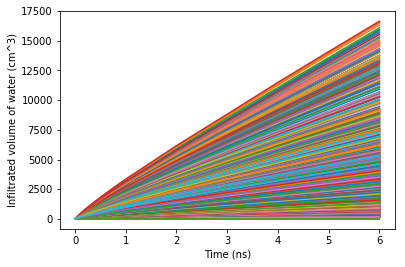

In [5]:
#Calcul des volumes
import matplotlib.pyplot as plt

#p=(0.03, 0.42000000000000004, 0.07, 0.01, 5.5, 0.08)
for p in itertools.product(tr,ts,ti,Ks,n,alpha):# Definition des paramètres MVG
    paramMVG=ParamMVG()

    paramMVG.tr = p[0]
    paramMVG.ts = p[1]
    paramMVG.ti = p[2]
    paramMVG.Ks = p[3]
    paramMVG.n = p[4]
    paramMVG.alpha = p[5]
    paramMVG.porosity = paramMVG.ts
    #dir = os.getcwd() #répertoire où on a lancer le script
    dir = "/home/clemence/Porchet-GPR/"
    myDirName = "OUT"+repr(geometry)+"/"+repr(paramMVG)+"/SWMS_2D.OUT/"
 
    if (not os.path.isfile(myDirName+"Balance.out")):
        print("Pas de Balance.out")
    else:
        #print("ok")
        InFlow=np.zeros(nT+1)
        dVolume=np.zeros(nT)
        Volume_infiltre=np.zeros(nT+1)

        i=0
        fVOL=open(myDirName+"Balance.out","r")
        #contenu = fVOL.read()
        print(myDirName)
        for ligne in fVOL:
            #print(ligne)
            if 'InFlow' in ligne:
                mots = ligne.split(" ")
                InFlow[i] = float(mots[10])
                i=i+1
        fVOL.close()

        dVolume[0] = temps[0] * InFlow[1]
        Volume_infiltre[1] = Volume_infiltre[0] + dVolume[0]
        for i in range(1,nT):
            #print(i)
            dVolume[i] = (temps[i] - temps[i-1]) * InFlow[i+1]
            Volume_infiltre[i+1] = Volume_infiltre[i] + dVolume[i]

        os.chdir(dir + "OUT"+repr(geometry)+"/"+repr(paramMVG))
        fvolsave=open("Volumes","w")
        fvolsave.write("""{}\n""".format(Volume_infiltre))
        fvolsave.close()
        os.chdir(dir)

        axe=np.zeros(nT+1)
        axe[1:nT+1]=temps
        plt.xlabel("Time (ns)")
        plt.ylabel("Infiltrated volume of water (cm^3)")
        plt.plot(axe,Volume_infiltre)

In [ ]:
(0.67-0.5)*492

In [ ]:
#Visualisation d'un radargramme et du bulbe...
from maillage_SWMS2D import maillage_SWMS2D
from maillage_GPRMAX import maillage_GPRMAX
from pygimli.mplviewer import drawMesh, drawModel
from pygimli.meshtools import interpolate
from pygimli.meshtools import nodeDataToCellData
#ts0.42000000000000004_ti0.07_tr0.03_n5.5_alpha0.08_Ks0.01
p=(0.03, 0.42000000000000004, 0.07, 0.01, 5.5, 0.08)
# Definition des paramètres MVG
paramMVG=ParamMVG()

paramMVG.tr = p[0]
paramMVG.ts = p[1]
paramMVG.ti = p[2]
paramMVG.Ks = p[3]
paramMVG.n = p[4]
paramMVG.alpha = p[5]
paramMVG.porosity = paramMVG.ts
   
myDirName = "OUT"+repr(geometry)+"/"+repr(paramMVG)
nom='radargram'
filename = nom + '__merged.out'
print(myDirName)
os.chdir(myDirName)

# Lecture des données radar
f = h5py.File(filename, 'r')
path = '/rxs/rx1/'
data = f['%s%s' % (path, 'Ez')][:,:]
plt.imshow(data,aspect=0.01)

# Lecture des teneurs en eau
f_thetas = "SWMS_2D.OUT/th.out" 
theta=np.loadtxt(f_thetas) 
[mesh, pg_pos, mesh_pos, mesh_cells]=maillage_SWMS2D(geometry)
[xv, yv, mx, my, mesh2, grid, grid_mat, eps_mat, sigma_grid_mat] = maillage_GPRMAX(paramGPRMAX, paramMVG, mesh, mesh_pos[:,:2], f_thetas, nT)
eps=np.zeros(len(theta))
for i in range(0,len(theta)):
    eps[i]=CRIM(theta[i], paramMVG, paramGPRMAX)

fig, ax = plt.subplots(nT+1, figsize=(20, 100))
for i in range(0, nT+1) : #
    grid=np.zeros([len(xv[:,0]), len(xv[0,:])])
    outdata=interpolate(mesh2,mesh,eps_mat[:,i], fill_value=eps[0])
    outdata2=nodeDataToCellData(mesh2,outdata)
    for j in range(0,len(xv[0,:])):
        k=j*len(xv[:,0])
        kk=len(xv[:,0])
        grid[:,j]=np.around(outdata[k:(k+kk)], decimals=2)
    grid_mat[i]=grid.T
    a=np.where(grid_mat[i]==0.0)
    grid_mat[i][a]=min(eps)
    b=np.where(grid_mat[i]<=eps[0])
    grid_mat[i][b]=eps[0]
    drawModel(ax[i], mesh2 , outdata2)

os.chdir(dir)